# Model Development

## Import necessary libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd

# Model development modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Import custom modules
from src.utils.data_loader import load_processed_data
from src.utils.visualization import plot_correlation_matrix
from src.utils.fgra import normalize_data, grey_relational_coefficient
from src.models.train import train_and_evaluate_models
from src.models.evaluate import evaluate_model
from src.models.optimize import optimize_model
from src.utils.model_persistence import save_model

## Load Preprocessed Data

In [3]:
# Load the dataset
data = pd.read_csv(load_processed_data())

# Display the first few rows to inspect the structure
data.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,65,77638,0,0,0,0,0,0,1,0,...,0,-1,-0.580761,0.331288,-0.170422,-0.518859,-0.144456,-0.575541,-0.096214,-0.154545
1,66,77511,0,0,0,0,0,0,1,0,...,0,-1,-0.620900,-0.438193,0.020004,0.139385,-0.074313,-0.123307,0.077921,0.437931
2,67,77130,0,0,0,0,0,0,1,0,...,0,-1,-0.139237,0.074794,-0.081472,0.109465,-0.018734,0.287815,-0.096214,-0.154545
3,68,71950,0,0,0,0,0,1,0,0,...,1,0,-1.544088,-1.207674,-0.184858,-0.847981,-0.164667,-1.027775,-0.096214,-0.154545
4,69,71805,0,0,0,0,0,0,1,0,...,0,0,0.342427,0.331288,0.048451,0.827549,0.165538,1.274508,-0.096214,-0.154545


## Feature Selection with Fuzzy GRA

### Fuzzification

In [42]:
normalized_data = normalize_data(data)
normalized_data.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,0.040534,0.035458,0.040534,0.040534,0.040534,0.040534,0.040534,0.040534,0.959466,0.040534,...,0.040534,0.040534,0.119914,0.164012,0.040443,0.038242,0.040442,0.038242,0.040511,0.040253
1,0.040532,0.035468,0.040534,0.040534,0.040534,0.040534,0.040534,0.040534,0.959466,0.040534,...,0.040534,0.040534,0.116183,0.095830,0.039800,0.033859,0.040273,0.036051,0.039560,0.036321
2,0.140219,0.135186,0.140223,0.140223,0.140223,0.140223,0.140223,0.140223,0.859777,0.140223,...,0.140223,0.140223,0.061269,0.041595,0.139832,0.133748,0.139828,0.133748,0.140200,0.139942
3,0.128483,0.123840,0.128489,0.128489,0.128489,0.128489,0.128489,0.871511,0.128489,0.128489,...,0.871511,0.871511,0.057593,0.060307,0.128446,0.128389,0.128446,0.128389,0.128466,0.128208
4,0.104770,0.100140,0.104778,0.104778,0.104778,0.104778,0.104778,0.104778,0.895222,0.104778,...,0.104778,0.895222,0.141491,0.099768,0.103948,0.093521,0.103939,0.093521,0.104755,0.104497


### Calculate Grey Relational Coefficient

In [43]:
reference_sequence = normalized_data['Story_Point'].mean()
coefficients = normalized_data.apply(lambda x: grey_relational_coefficient(x, reference_sequence))
# Drop the target column as we don't need its relational coefficient with itself
coefficients = coefficients.drop(columns=['Story_Point'])
# normalized_data['story_similarity'] = coefficients

In [44]:
# Calculate the absolute difference between each feature and the target (Story_Point)
deltas = abs(normalized_data.drop(columns='Story_Point') - normalized_data['Story_Point'].values.reshape(-1, 1))

# Calculate delta_min and delta_max
delta_min = deltas.min().min()
delta_max = deltas.max().max()

# Calculate Grey Relational Coefficients (GRC) using the formula
rho = 0.5
GRC = (delta_min + rho * delta_max) / (deltas + rho * delta_max)

GRC.head()

,ID,Jira_ID,Status_0,Status_1,Status_2,Status_3,Status_4,Status_5,Status_6,Resolution_0,...,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,0.925012,0.933780,0.925012,0.925012,0.925012,0.925012,0.925012,0.925012,0.342591,0.925012,...,0.925012,0.925012,0.806563,0.752999,0.925168,0.928950,0.925169,0.928950,0.925051,0.925493
1,0.925015,0.933763,0.925012,0.925012,0.925012,0.925012,0.925012,0.925012,0.342591,0.925012,...,0.925012,0.925012,0.811448,0.839165,0.926269,0.936577,0.925458,0.932748,0.926681,0.932277
2,0.780982,0.787171,0.780978,0.780978,0.780978,0.780978,0.780978,0.780978,0.367707,0.780978,...,0.780978,0.780978,0.890838,0.923199,0.781455,0.788957,0.781460,0.788957,0.781006,0.781320
3,0.795567,0.801488,0.795559,0.795559,0.795559,0.795559,0.795559,0.364561,0.795559,0.795559,...,0.364561,0.364561,0.896711,0.892368,0.795613,0.795686,0.795614,0.795686,0.795589,0.795915
4,0.826761,0.833139,0.826750,0.826750,0.826750,0.826750,0.826750,0.826750,0.358366,0.826750,...,0.826750,0.358366,0.779434,0.833656,0.827886,0.842431,0.827899,0.842431,0.826781,0.827134


### Compute Grey Relational Grade

In [45]:
# Calculate Grey Relational Grade (GRG) for each feature
# GRC = coefficients
GRG = GRC.mean()

# Sorting the features based on GRG
GRG_sorted = GRG.sort_values(ascending=False)

GRG_sorted

Jira_ID                                 0.879902
Description_Unique_Words                0.869595
Description_Text_Unique_Words           0.868676
Total_Effort_Minutes                    0.863733
Description_Code_Unique_Words           0.862883
Description_Length                      0.862092
In_Progress_Minutes                     0.861999
Description_Code_Length                 0.861847
Description_Text_Length                 0.861768
Resolution_Time_Minutes                 0.861016
Status_0                                0.860520
Story_Point_Changed_After_Estimation    0.851382
Status_1                                0.849885
Title_Unique_Words                      0.843925
Status_3                                0.840669
Sprint_ID                               0.833646
Resolution_1                            0.828054
Status_2                                0.813083
Resolution_0                            0.806339
Title_Length                            0.800852
Title_Changed_After_

### Feature Ranking

In [46]:
# Rank the Features based on GRG
ranked_features = GRG_sorted
ranked_features

Jira_ID                                 0.879902
Description_Unique_Words                0.869595
Description_Text_Unique_Words           0.868676
Total_Effort_Minutes                    0.863733
Description_Code_Unique_Words           0.862883
Description_Length                      0.862092
In_Progress_Minutes                     0.861999
Description_Code_Length                 0.861847
Description_Text_Length                 0.861768
Resolution_Time_Minutes                 0.861016
Status_0                                0.860520
Story_Point_Changed_After_Estimation    0.851382
Status_1                                0.849885
Title_Unique_Words                      0.843925
Status_3                                0.840669
Sprint_ID                               0.833646
Resolution_1                            0.828054
Status_2                                0.813083
Resolution_0                            0.806339
Title_Length                            0.800852
Title_Changed_After_

### Visualise the feature importance

[2023-09-08 03:53:11,204] 876 matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7efbdff26410>


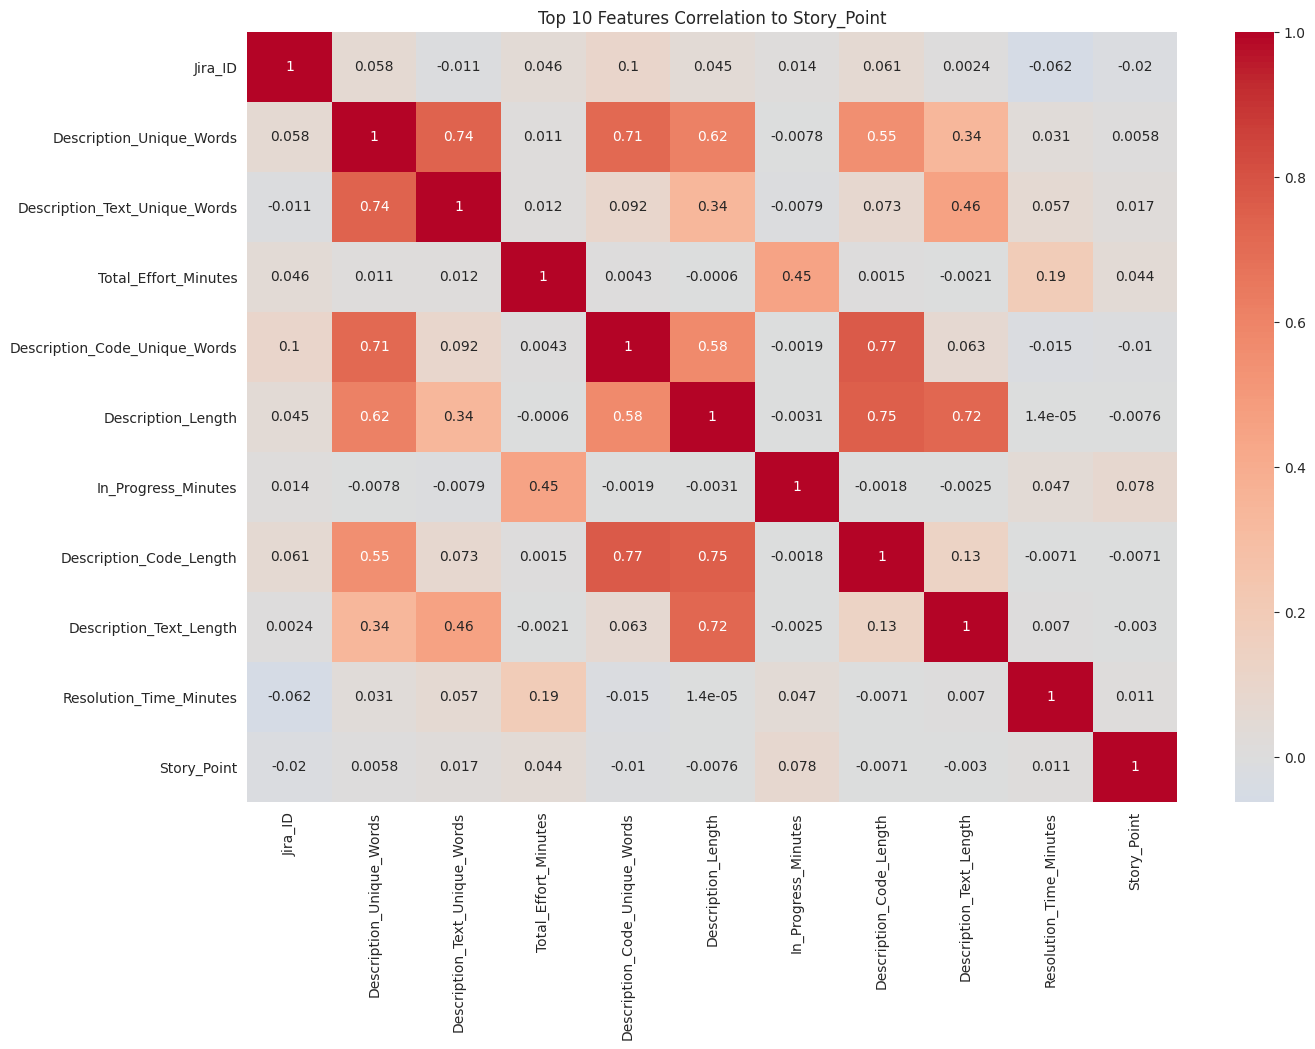

In [52]:
top_features_with_highest_ranking_with_sp = ranked_features.index[:10]

# Create a smaller correlation matrix with only the top features including 'Story_Point'
fgra_correlation_matrix = data[top_features_with_highest_ranking_with_sp].join(data['Story_Point']).corr()
plot_correlation_matrix(fgra_correlation_matrix, 'Top 10 Features Correlation to Story_Point')

# Model Development

## Data Splitting

## Train Models without FGRA Features

### Data Splitting

In [26]:
# Features and target variable
X = data.drop(columns=['Story_Point'])
y = data['Story_Point']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Model Training

In [27]:
%%time
models_without_fgra = [
    ('Linear Regression (Baseline Model)', LinearRegression()),
    ('Random Forest Regression', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting Regression', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (ANN)', None),
]
trained_models_without_fgra = train_and_evaluate_models(models_without_fgra, X_train, y_train, X_test, y_test)

Linear Regression (Baseline Model) Metrics:
MSE: 0.08902633612557345
RMSE: 0.2983728139854123
MAE: 0.09424778514171857

Random Forest Regression Metrics:
MSE: 0.08555254960514906
RMSE: 0.2924936744703192
MAE: 0.09629278354869467

Gradient Boosting Regression Metrics:
MSE: 0.07703014802249751
RMSE: 0.27754305615975605
MAE: 0.09085583489809577

Epoch 1/100
10740/10740 [==============================] - 24s 2ms/step - loss: 329066.2188 - val_loss: 0.5533
Epoch 2/100
10740/10740 [==============================] - 17s 2ms/step - loss: 1755.0839 - val_loss: 0.2145
Epoch 3/100
10740/10740 [==============================] - 16s 1ms/step - loss: 15.8046 - val_loss: 0.0928
Epoch 4/100
10740/10740 [==============================] - 15s 1ms/step - loss: 16.4829 - val_loss: 0.0913
Epoch 5/100
10740/10740 [==============================] - 15s 1ms/step - loss: 1.6932 - val_loss: 0.0914
Epoch 6/100
10740/10740 [==============================] - 16s 1ms/step - loss: 0.2698 - val_loss: 0.0912
Epoch 7/1

## Train Models with FGRA Features

### Data Splitting

In [35]:
selected_features = ranked_features.index[:25]
X_selected = data[selected_features]
y_selected = data['Story_Point']

# Splitting the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.25, random_state=42)

### Model Training

In [37]:
%%time
models_with_fgra = [
    ('Random Forest (with FGRA Features)', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting (with FGRA Features)', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Artificial Neural Networks (with FGRA Features)', None),
]
predictions_with_fgra = train_and_evaluate_models(models_with_fgra, X_train_selected, y_train_selected, X_test_selected, y_test_selected)

Random Forest (with FGRA Features) Metrics:
MSE: 0.05519448005383362
RMSE: 0.23493505497016323
MAE: 0.07765938493760571

Gradient Boosting (with FGRA Features) Metrics:
MSE: 0.06286673404672637
RMSE: 0.2507323952877377
MAE: 0.08465969061312431


Epoch 1/100
10740/10740 [==============================] - 22s 2ms/step - loss: 89967392.0000 - val_loss: 1.8233
Epoch 2/100
10740/10740 [==============================] - 22s 2ms/step - loss: 12332.4268 - val_loss: 0.7403
Epoch 3/100
10740/10740 [==============================] - 23s 2ms/step - loss: 99.6055 - val_loss: 0.0914
Epoch 4/100
10740/10740 [==============================] - 22s 2ms/step - loss: 3814.6089 - val_loss: 0.0928
Epoch 5/100
10740/10740 [==============================] - 22s 2ms/step - loss: 1.6140 - val_loss: 0.0914
Epoch 6/100
10740/10740 [==============================] - 23s 2ms/step - loss: 998.7576 - val_loss: 0.0915
Epoch 7/100
10740/10740 [==============================] - 20s 2ms/step - loss: 131.4503 - val_loss: 

# Model Optimization

## Optimized the best model

In [38]:
best_model = predictions_with_fgra['Random Forest (with FGRA Features)']

In [ ]:
# optimize_model(best_model)

# Model Persistence

In [40]:
# Save model
save_model(best_model)

[2023-09-08 00:11:33,920] 8 src.utils.logger - INFO - Model successfully saved to: /home/umar/Workspace/personal/msc-dissertation/src/utils/../../artifacts/models/effort_estimation_model.joblib
